### Ross Ice Shelf Map
```
pip3 install --user ipywidgets
jupyter nbextension install --user --py widgetsnbextension
jupyter nbextension enable --user --py widgetsnbextension
jupyter-notebook
```

#### Load modules

In [1]:
import os
import pyproj
import datetime
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

from pyTMD.calc_delta_time import calc_delta_time
from pyTMD.read_tide_model import extract_tidal_constants
from pyTMD.read_netcdf_model import extract_netcdf_constants
from pyTMD.read_GOT_model import extract_GOT_constants
from pyTMD.infer_minor_corrections import infer_minor_corrections
from pyTMD.predict_tide import predict_tide

#-- set the directory with tide models
dirText = widgets.Text(
    value=os.getcwd(),
    description='Directory:',
    disabled=False
)
display(dirText)

#-- dropdown menu for setting tide model
model_list = ['CATS0201','CATS2008','TPXO9-atlas','TPXO9.1',
    'TPXO8-atlas','TPXO7.2','GOT4.7','GOT4.8','GOT4.10']
modelDropdown = widgets.Dropdown(
    options=model_list,
    value='CATS2008',
    description='Model:',
    disabled=False,
)
display(modelDropdown)

Text(value='', description='Directory:')

Dropdown(description='Model:', index=1, options=('CATS0201', 'CATS2008', 'TPXO9-atlas', 'TPXO9.1', 'TPXO8-atla…

#### Setup tide model parameters

In [2]:
#-- directory with tide models
tide_dir = os.path.expanduser(dirText.value)
MODEL = modelDropdown.value
if (MODEL == 'CATS0201'):
    grid_file = os.path.join(tide_dir,'cats0201_tmd','grid_CATS')
    model_file = os.path.join(tide_dir,'cats0201_tmd','h0_CATS02_01')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'CATS2008'):
    grid_file = os.path.join(tide_dir,'CATS2008','grid_CATS2008a_opt')
    model_file = os.path.join(tide_dir,'CATS2008','hf.CATS2008.out')
    model_format = 'OTIS'
    EPSG = 'CATS2008'
    TYPE = 'z'
elif (MODEL == 'TPXO9-atlas'):
    model_directory = os.path.join(tide_dir,'TPXO9_atlas')
    grid_file = 'grid_tpxo9_atlas.nc.gz'
    model_files = ['h_q1_tpxo9_atlas_30.nc.gz','h_o1_tpxo9_atlas_30.nc.gz',
        'h_p1_tpxo9_atlas_30.nc.gz','h_k1_tpxo9_atlas_30.nc.gz',
        'h_n2_tpxo9_atlas_30.nc.gz','h_m2_tpxo9_atlas_30.nc.gz',
        'h_s2_tpxo9_atlas_30.nc.gz','h_k2_tpxo9_atlas_30.nc.gz',
        'h_m4_tpxo9_atlas_30.nc.gz','h_ms4_tpxo9_atlas_30.nc.gz',
        'h_mn4_tpxo9_atlas_30.nc.gz','h_2n2_tpxo9_atlas_30.nc.gz']
    model_format = 'netcdf'
    TYPE = 'z'
    SCALE = 1.0/1000.0
elif (MODEL == 'TPXO9.1'):
    grid_file = os.path.join(tide_dir,'TPXO9.1','DATA','grid_tpxo9')
    model_file = os.path.join(tide_dir,'TPXO9.1','DATA','h_tpxo9.v1')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'TPXO8-atlas'):
    grid_file = os.path.join(tide_dir,'tpxo8_atlas','grid_tpxo8atlas_30_v1')
    model_file = os.path.join(tide_dir,'tpxo8_atlas','hf.tpxo8_atlas_30_v1')
    model_format = 'ATLAS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'TPXO7.2'):
    grid_file = os.path.join(tide_dir,'TPXO7.2_tmd','grid_tpxo7.2')
    model_file = os.path.join(tide_dir,'TPXO7.2_tmd','h_tpxo7.2')
    model_format = 'OTIS'
    EPSG = '4326'
    TYPE = 'z'
elif (MODEL == 'GOT4.7'):
    model_directory = os.path.join(tide_dir,'GOT4.7','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    c = ['q1','o1','p1','k1','n2','m2','s2','k2','s1','m4']
    model_format = 'GOT'
    SCALE = 1.0/100.0
elif (MODEL == 'GOT4.8'):
    model_directory = os.path.join(tide_dir,'got4.8','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    c = ['q1','o1','p1','k1','n2','m2','s2','k2','s1','m4']
    model_format = 'GOT'
    SCALE = 1.0/100.0
elif (MODEL == 'GOT4.10'):
    model_directory = os.path.join(tide_dir,'GOT4.10c','grids_oceantide')
    model_files = ['q1.d.gz','o1.d.gz','p1.d.gz','k1.d.gz','n2.d.gz',
        'm2.d.gz','s2.d.gz','k2.d.gz','s1.d.gz','m4.d.gz']
    c = ['q1','o1','p1','k1','n2','m2','s2','k2','s1','m4']
    model_format = 'GOT'
    SCALE = 1.0/100.0

#### Setup coordinates for calculating tides

In [3]:
#-- create an image around the Ross Ice Shelf
xlimits = [-740000,520000]
ylimits = [-1430000,-300000]
x = np.arange(xlimits[0],xlimits[1]+5e3,5e3)
y = np.arange(ylimits[1],ylimits[0]-5e3,-5e3)
nx,ny = (len(x), len(y))
xgrid,ygrid = np.meshgrid(x,y)
#-- convert image coordinates from polar stereographic to latitude/longitude
proj1 = pyproj.Proj("+init=EPSG:{0:d}".format(4326))
proj2 = pyproj.Proj("+init=EPSG:{0:d}".format(3031))
lon,lat = pyproj.transform(proj2, proj1, xgrid.flatten(), ygrid.flatten())

#### Setup date for calculating tides

In [4]:
datepick = widgets.DatePicker(
    description='Date:',
    value = datetime.date.today(),
    disabled=False
)
display(datepick)

DatePicker(value=datetime.date(2019, 11, 21), description='Date:')

#### Calculate tide map

In [5]:
#-- convert from calendar date to days relative to Jan 1, 1992 (48622 MJD)
YMD = datepick.value
tide_time = 367.0*YMD.year - \
    np.floor(7.0*(YMD.year + np.floor((YMD.month+9.0)/12.0))/4.0) - \
    np.floor(3.0*(np.floor((YMD.year + (YMD.month - 9.0)/7.0)/100.0) + 1.0)/4.0) + \
    np.floor(275.*YMD.month/9.0) + YMD.day - 727594.0

#-- read tidal constants and interpolate to grid points
if model_format in ('OTIS','ATLAS'):
    amp,ph,D,c = extract_tidal_constants(lon, lat, grid_file, model_file,
        EPSG, TYPE, METHOD='spline', GRID=model_format)
    DELTAT = np.zeros_like(tide_time)
elif (model_format == 'netcdf'):
    amp,ph,D,c = extract_netcdf_constants(lon, lat, model_directory,
        grid_file, model_files, TYPE, METHOD='spline', SCALE=SCALE)
    DELTAT = np.zeros_like(tide_time)
elif (model_format == 'GOT'):
    amp,ph = extract_GOT_constants(lon, lat, model_directory, model_files,
        METHOD='spline', SCALE=SCALE)
    #-- convert time to Modified Julian Days for calculating deltat
    delta_file = os.path.join(tide_dir,'deltat.data')
    DELTAT = calc_delta_time(delta_file, tide_time + 48622.0)

#-- calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
#-- calculate constituent oscillation
hc = amp*np.exp(cph)

#-- predict tidal elevations at time and infer minor corrections
TIDE = predict_tide(tide_time, hc, c, DELTAT=DELTAT,
    CORRECTIONS=model_format)
MINOR = infer_minor_corrections(tide_time, hc, c,
    DELTAT=DELTAT, CORRECTIONS=model_format)
#-- add major and minor components and reform grid
#-- convert from meters to centimeters
tide_cm = 100.0*np.reshape((TIDE+MINOR),(ny,nx))

#### Create image of tidal oscillation

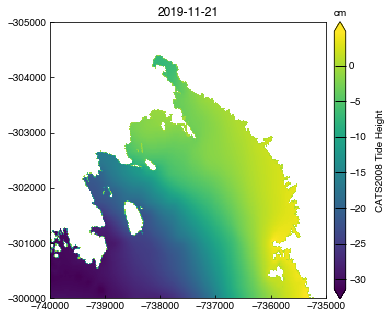

In [6]:
#-- output Ross Ice Shelf Tide Image
fig, ax = plt.subplots(num=1, figsize=(6,6))
#-- plot tide height
im = ax.imshow(tide_cm, extent=(x[0],x[1],y[0],y[1]),
    origin='upper', interpolation='nearest')

#-- Add colorbar and adjust size
#-- pad = distance from main plot axis
#-- extend = add extension triangles to upper and lower bounds
#-- options: neither, both, min, max
#-- shrink = percent size of colorbar
#-- aspect = lengthXwidth aspect of colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.025, extend='both',
    extendfrac=0.0375, shrink=0.85, aspect=22.5, drawedges=False)
#-- rasterized colorbar to remove lines
cbar.solids.set_rasterized(True)
#-- Add label to the colorbar
cbar.ax.set_ylabel('{0} Tide Height'.format(MODEL), labelpad=10)
cbar.ax.set_xlabel('cm')
cbar.ax.xaxis.set_label_coords(0.50, 1.045)
#-- ticks lines all the way across
cbar.ax.tick_params(which='both', width=1, length=11, direction='in')
#-- add title (date)
ax.set_title(YMD)
#-- adjust ticks to be inward
ax.get_xaxis().set_tick_params(which='both', direction='in')
ax.get_yaxis().set_tick_params(which='both', direction='in')
plt.show()